In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os; os.chdir("..")
import pqr
os.chdir("./examples/")

## Считываем данные

In [3]:
prices = pd.read_csv("factors/italy/close_price.csv", parse_dates=True, index_col=0)["2000":]
pe = pd.read_csv("factors/italy/pe.csv", parse_dates=True, index_col=0)["2000":]
mcap = pd.read_csv("factors/italy/mcap.csv", parse_dates=True, index_col=0)["2000":]
volume = pd.read_csv("factors/italy/trading_volume.csv", parse_dates=True, index_col=0)["2000":]
volume = prices * volume  # convert volume from lots to money

prices, pe, mcap, volume = pqr.utils.replace_with_nan(prices, pe, mcap, volume, to_replace=0)
prices, pe, mcap, volume = pqr.utils.align(prices, pe, mcap, volume)

## Генерируем бенчмарк, создаем дашборд

In [4]:
benchmark = pqr.universe_as_benchmark(
    prices=prices,
)

In [5]:
table = pqr.utils.partial(
    pqr.metrics.show_table,
    metrics={
        "Monthly Mean Return, %": pqr.metrics.fancy_format(
            pqr.metrics.mean_return,
            multiplier=100,
            statistics=True,
            annualizer=1,
        ),
        "Monthly Volatility, %": pqr.metrics.fancy_format(
            pqr.metrics.volatility,
            multiplier=100,
            annualizer=1,
        ),
        "Maximum Drawdown, %": pqr.metrics.fancy_format(
            pqr.metrics.max_drawdown,
            multiplier=100,
        ),
        "Sharpe Ratio": pqr.metrics.fancy_format(
            pqr.metrics.sharpe_ratio,
            rf=0,
        ),
        "Mean Excess Return, %": pqr.metrics.fancy_format(
            pqr.metrics.mean_excess_return,
            multiplier=100,
            benchmark=benchmark,
        ),
        "Alpha, %": pqr.metrics.fancy_format(
            pqr.metrics.alpha,
            multiplier=100,
            benchmark=benchmark,
            statistics=True,
        ),
        "Beta": pqr.metrics.fancy_format(
            pqr.metrics.beta,
            benchmark=benchmark,
        ),
    }
)
chart = pqr.utils.partial(
    pqr.metrics.plot_chart,
    metrics={
        "Compounded Returns": pqr.metrics.compounded_returns,
    },
    benchmark=benchmark,
    figsize=(16, 9),
)

summary = pqr.utils.partial(
    pqr.metrics.display_dashboard,
    items=[table, chart]
)

## Строим факторные портфели

In [6]:
mean_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.look_back_mean, period=3),
    pqr.utils.partial(pqr.hold, period=3),
)

value = mean_transform(pe)
size = mean_transform(mcap)

In [7]:
portfolios = pqr.backtest_factor_portfolios(
    factor=value,
    prices=prices,
    strategies=pqr.split_quantiles(3),
    allocation=pqr.utils.compose(
        pqr.equal_weights,
        pqr.utils.partial(
            pqr.allocate_cash,
            prices=prices,
            capital=1_000_000,
            fee=0.0005
        )
    ),
    add_wml=True,
)

## После обучения у факторной модели появились портфели. С ними можно работать по отдельности

In [8]:
portfolios[0].returns

Winners
2000-04-28    0.000000
2000-05-31    0.021695
2000-06-30    0.026927
2000-07-31    0.018009
2000-08-31    0.081895
                ...   
2021-04-30    0.043795
2021-05-31    0.060443
2021-06-30   -0.002077
2021-07-30    0.001863
2021-08-31    0.000000
Name: returns, Length: 257, dtype: float64

In [9]:
pqr.metrics.alpha(portfolios[0], benchmark, statistics=True)

(0.03853791861864532, 2.7868341955130513, 0.005722817160180613)

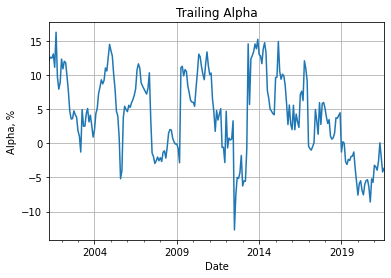

In [10]:
(pqr.metrics.trailing_alpha(portfolios[0], benchmark) * 100).plot()

plt.title("Trailing Alpha")
plt.xlabel("Date")
plt.ylabel("Alpha, %")
plt.grid();

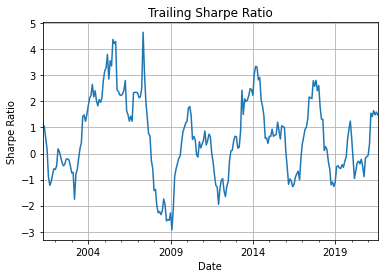

In [11]:
pqr.metrics.trailing_sharpe_ratio(portfolios[0]).plot()

plt.title("Trailing Sharpe Ratio")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid();

In [12]:
pqr.metrics.max_drawdown(portfolios[0])

-0.6586363699085966

## Сравниваем портфели 

,Winners,Neutral 1,Losers,WML
"Monthly Mean Return, %",0.64** (1.74),0.57** (1.86),0.34 (1.12),0.07 (0.57)
"Monthly Volatility, %",5.89,4.90,4.82,2.11
"Maximum Drawdown, %",-65.86,-59.79,-63.80,-33.03
Sharpe Ratio,0.38,0.40,0.24,0.12
"Mean Excess Return, %",3.90,3.02,0.24,-2.89
"Alpha, %",3.85*** (2.79),3.64*** (2.96),0.90 (0.78),0.22 (0.16)
Beta,1.01,0.83,0.83,0.18


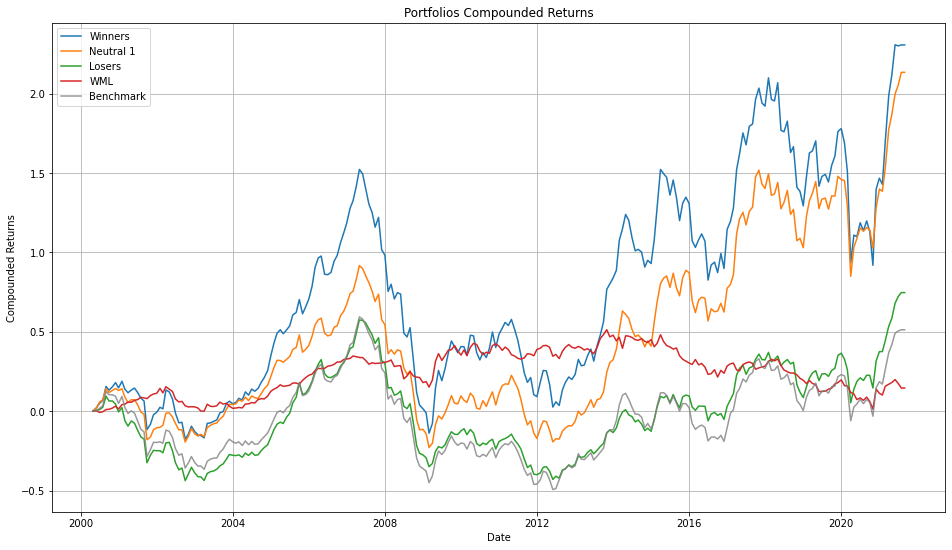

In [13]:
summary(portfolios)

## grid_search

In [14]:
def mean_transform_factory(looking, lag, holding):
    return pqr.utils.compose(
        pqr.utils.partial(pqr.look_back_mean, period=looking),
        pqr.utils.partial(pqr.lag, period=lag),
        pqr.utils.partial(pqr.hold, period=holding),
    )


transforms_grid = {
    "(1, 0, 1)": mean_transform_factory(1, 0, 1),
    "(1, 1, 1)": mean_transform_factory(1, 1, 1),
    "(3, 0, 3)": mean_transform_factory(3, 0, 3),
    "(3, 1, 3)": mean_transform_factory(3, 1, 3),
    "(6, 0, 6)": mean_transform_factory(6, 0, 6),
    "(6, 1, 6)": mean_transform_factory(6, 1, 6),
    "(9, 0, 9)": mean_transform_factory(9, 0, 9),
    "(9, 1, 9)": mean_transform_factory(9, 1, 9),
    "(12, 0, 12)": mean_transform_factory(12, 0, 12),
    "(12, 1, 12)": mean_transform_factory(12, 1, 12),
}

results = pqr.grid_search_factor_portfolios(
    prices=prices,
    strategies=pqr.split_quantiles(3),
    factor=pe,
    transforms=transforms_grid,
    metric=pqr.metrics.mean_return,
    add_wml=True,
)

/home/akbabkin/programming/notebooks/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [15]:
results

,Winners,Neutral 1,Losers,WML
"(1, 0, 1)",0.081074,0.064644,0.036096,0.016663
"(1, 1, 1)",0.074226,0.069362,0.035507,0.004650
"(3, 0, 3)",0.076663,0.067183,0.039177,0.009598
"(3, 1, 3)",0.066013,0.068885,0.037769,-0.002650
"(6, 0, 6)",0.067252,0.063874,0.043479,0.003321
"(6, 1, 6)",0.061425,0.068701,0.037295,-0.007202
"(9, 0, 9)",0.064241,0.066804,0.031704,-0.002793
"(9, 1, 9)",0.061188,0.068095,0.028748,-0.007098
"(12, 0, 12)",0.066965,0.067739,0.029883,-0.000764
"(12, 1, 12)",0.068885,0.066858,0.029259,0.002062


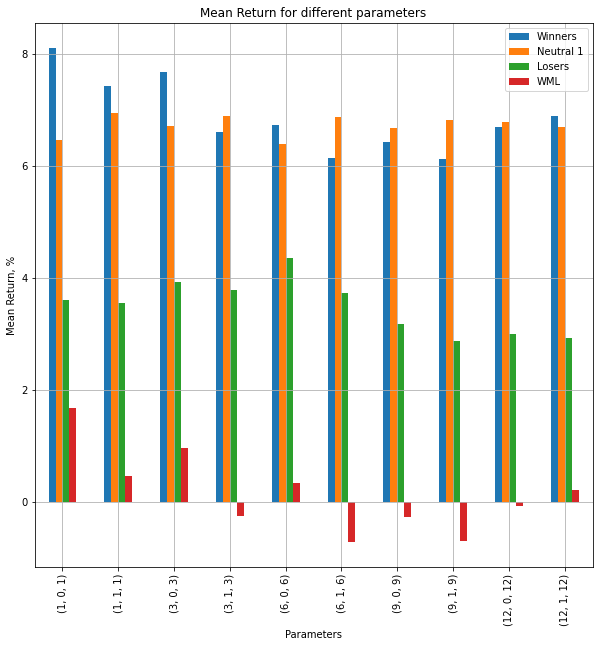

In [16]:
(results * 100).plot.bar(figsize=(10, 10))
plt.title("Mean Return for different parameters")
plt.xlabel("Parameters")
plt.ylabel("Mean Return, %")
plt.grid();